# Loading Data

The dataset consists of detection *events*, wherein a variable number of particles come into contact with the detector's cells. The location of these impacts are called *hits*, and there are likewise a variable number of them per particle.

In [1]:
import pickle
import numpy as np

with open('tracks.pickle', 'rb') as f:
    samples = pickle.load(f)

print("Loaded {} samples.".format(len(samples)))

Loaded 100 samples.


### Features

Each sample contains a set of hits, and each hit contains the following information:

* *x,y,z* coordinates
* Cell count and impact magnitude
* A learned hit embedding, output from the previous graph creation stage
* Ground truth cluster ID, denoting the particle which created the hit

Additionally, samples contain graphs as output from the previous stage which aims to connect hits created by the same particle. The two graphs included are

* A predicted graph, the raw output from the graph building stage
* An augmented graph, which contains the predicted graph, plus any connections missed between hits created by the same particle. This is used in the GNN's loss function.

### Visualizations

Choosing a sample to explore, one can see how the embedding differs from the raw features for graph creation.

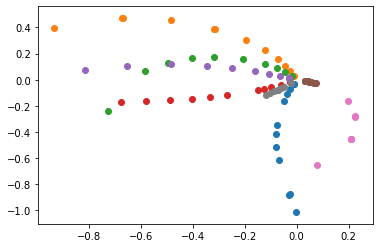

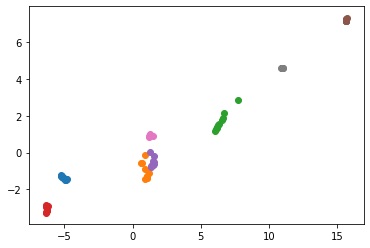

<Figure size 432x288 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_clusters(x,y,pid):
    for g in np.unique(pid):
        i = np.where(pid == g)
        plt.scatter(x[i],y[i], label=g)
    plt.show()
    plt.clf()

hits = samples[1]['hits']
xyz = hits['xyz']
emb = hits['emb']
pid = hits['particle_id']

# Hit coordinates
plot_clusters(xyz[:,0], xyz[:,1], pid)

# Emb coordinates
plot_clusters(emb[:,0], emb[:,1], pid)

Clearly, the embedding will lead to superior clustering as compared with the raw *x,y,z* positions. However, this embedding incorporates information from only each hit individually. With a GNN, one can create node embeddings which incorporate information from the hit's neighborhood. As we will see, this allows for superior embeddings and thus improved performance in clustering.

# Model

The GNN model chosen is a simple message-passing architecture. One layer concatenates each node's features with an aggregation of the node's neighborhood, before applying a transformation via a fully-connected neural network layer.

The output of the model is a set of node embeddings, where this new embedding has the same goal as in the graph building stage: according to some distance metric, node pairs whose hits belong to the same particle should be close, and otherwise they should be far.

In [3]:
import dgl
import torch
import torch.nn as nn

### Kernel
A multi-layer preceptron kernel determines edge weights of the graph at each layer.
Here, each edge is represented by the features of its adjoining nodes.
These features are passed through the MLP to produce an edge weight between 0 and 1.

In [4]:
class MLP_Kernel_DGL(nn.Module):
    def __init__(self, nb_input, nb_hidden_gnn, nb_output=1, nb_layer=1):
        super(MLP_Kernel_DGL, self).__init__()
        layers = [nn.Linear(nb_input*2, nb_hidden_gnn)]
        for _ in range(nb_layer-1):
            layers.append(nn.Linear(nb_hidden_gnn, nb_hidden_gnn))
        layers.append(nn.Linear(nb_hidden_gnn, nb_output))
        self.layers = nn.ModuleList(layers)
        self.act1 = nn.ReLU()
        self.act2 = nn.Sigmoid()

    def forward(self, g):
        g.apply_edges(self.mlp)
        return g

    def mlp(self, e):
        # Gather features from all relevant node pairs
        src = e.src['feat']
        dst = e.dst['feat']
        e_feats = torch.cat((src,dst),dim=1)
        
        # Apply MLP layers to node pairs
        for l in self.layers[:-1]:
            e_feats = self.act1(l(e_feats))
        
        # Apply final output with sigmoid
        e_feats = self.layers[-1](e_feats)
        e_feats = self.act2(e_feats)
        return {'e':e_feats}

### Graph convolution
Each node concatenated its starting features with its aggregated incoming messages.
Then, an affine transformation and ReLU activation are applied to produce a new representation for that node.

In [5]:
# Convolution operation on graph
class DGL_Convolution(nn.Module):
    def __init__(self,
               input_dim,
               nb_hidden_gnn):
        super(DGL_Convolution, self).__init__()
        self.weights = nn.Linear(2*input_dim, nb_hidden_gnn)
        self.act = nn.ReLU()

    def forward(self, n):
        feats = n.data['feat']
        agg_msg = n.data['agg_msg']
        node_feats = torch.cat((feats, agg_msg), dim=1)
        emb = self.weights(node_feats)
        emb = self.act(emb)
        return {'emb':emb}

### GNN Layer
Each GNN layer first, if applicable, normalizes the incoming graph nodes, updates the graph weighting based on that layer's kernel, then applies graph convolution.

In [6]:
# Complete GNN layer, including normalization, graph weighting, and convolution
def weighted_msg(e):
    return {'msg': e.src['feat'] * e.data['e']}

class GNN_Layer(nn.Module):
    def __init__(self, input_dim, nb_hidden_gnn, nb_hidden_kernel, apply_norm=True):
        super(GNN_Layer, self).__init__()

        self.kernel = MLP_Kernel_DGL(input_dim, nb_hidden_kernel)
        self.gconv = DGL_Convolution(input_dim, nb_hidden_gnn)
        self.bn = nn.BatchNorm1d(input_dim,momentum=0.10) if apply_norm else None

    def forward(self, g, features):
        # maybe apply normalization
        if self.bn is not None:
            features = self.bn(features)
        g.ndata['feat'] = features

        # set edge weights for this layer
        g = self.kernel(g)
        
        # send weighted messages and apply graph convolution to nodes
        g.send_and_recv(g.edges(),
                        message_func=weighted_msg,
                        reduce_func=dgl.function.sum(msg='msg', out='agg_msg'),
                        apply_node_func=self.gconv)
        g.ndata.pop('feat')
        g.ndata.pop('agg_msg')
        return g.ndata.pop('emb')

### GNN
The GNN consists of several layers as defined above. 
A final embedding layer takes the node features as output by the GNN layers, and applies an affine transformation to a low dimension space as defined by emb_dim.

In [7]:
class GNN(nn.Module):
  def __init__(self, nb_hidden_gnn, nb_layer, nb_hidden_kernel, input_dim, emb_dim=2):
    super(GNN, self).__init__()

    # Construct GNN Layers
    gnn_layers = [GNN_Layer(input_dim, nb_hidden_gnn, nb_hidden_kernel, apply_norm=True)]
    for _ in range(nb_layer-1):
        gnn_layers.append(GNN_Layer(nb_hidden_gnn, nb_hidden_gnn, nb_hidden_kernel))
    self.layers = nn.ModuleList(gnn_layers)

    self.final_emb = nn.Linear(nb_hidden_gnn, emb_dim)

  def forward(self, g):
    if torch.cuda.is_available():
        g.ndata['feat'] = g.ndata.pop('feat').to('cuda', non_blocking=True)

    emb = g.ndata.pop('feat')
    for i, layer in enumerate(self.layers):
      emb = layer(g, emb)
    emb = self.final_emb(emb)
    return emb

# Dataset, Dataloader

The TrackML_Dataset class is a PyTorch Dataset subclass, for use in a DataLoader class.
The trackml_collate function should be used when instantiating the DataLoader class for minibatch training.

Each sample will contain a graph (with features) used as input, and a graph with ground truth information.

In [8]:
from gnn_utils import TrackML_Dataset
from gnn_utils import trackml_collate

# Training

### Setup

In [9]:
import torch.nn.functional as F
from torch.utils.data import DataLoader

# PARAMETERS
batch_size = 4
nb_hidden = 32
nb_layers = 4
learn_rate = 0.001

dataset = TrackML_Dataset(samples)
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        collate_fn=trackml_collate, 
                        drop_last=True, 
                        shuffle=True,
                        num_workers=0)

net = GNN(nb_hidden, nb_layers, nb_hidden, 6)
optim = torch.optim.Adamax(net.parameters(), lr=learn_rate)
print(net)

GNN(
  (layers): ModuleList(
    (0): GNN_Layer(
      (kernel): MLP_Kernel_DGL(
        (layers): ModuleList(
          (0): Linear(in_features=12, out_features=32, bias=True)
          (1): Linear(in_features=32, out_features=1, bias=True)
        )
        (act1): ReLU()
        (act2): Sigmoid()
      )
      (gconv): DGL_Convolution(
        (weights): Linear(in_features=12, out_features=32, bias=True)
        (act): ReLU()
      )
      (bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): GNN_Layer(
      (kernel): MLP_Kernel_DGL(
        (layers): ModuleList(
          (0): Linear(in_features=64, out_features=32, bias=True)
          (1): Linear(in_features=32, out_features=1, bias=True)
        )
        (act1): ReLU()
        (act2): Sigmoid()
      )
      (gconv): DGL_Convolution(
        (weights): Linear(in_features=64, out_features=32, bias=True)
        (act): ReLU()
      )
      (bn): BatchNorm1d(32, eps=1e-05, momentum=0.

### Loss
Hinge embedding loss produces embeddings which are amenable to clustering.
Here a DGL edge function is used.

In [10]:
def get_emb_for_loss(e):
    src = e.src['emb']
    dst = e.dst['emb']
    truth = e.data['truth']
    pred_dst = nn.functional.pairwise_distance(src, dst)
    true_dst = truth*2 -1
    loss = nn.functional.hinge_embedding_loss(pred_dst, true_dst, reduction='none')
    return {'loss':loss, 'pred_dst':pred_dst, 'true_dst':true_dst}

### Accuracy
An accuracy proxy helps as a sanity check during training.

In [11]:
def score_dist_accuracy(pred, true):
    pred = pred.round()
    pred[pred!=0] = 1
    pred = 1-pred
    correct = pred==true
    nb_correct = correct.sum()
    nb_total = true.size(0)
    score = float(nb_correct.item()) / nb_total
    return score

### Training
Train over the dataset for a few epochs. 

In [18]:
def train_one_epoch(net, batch_size, optimizer, train_loader):
    net.train()

    nb_batch = len(train_loader)
    nb_train = nb_batch * batch_size
    epoch_score = 0
    epoch_loss  = 0

    print("\nTraining on {} samples".format(nb_train))
    for i, (g_input, g_true) in enumerate(train_loader):
        optimizer.zero_grad()
        
        f = g_input.ndata['feat']
        g_true.ndata['emb'] = net(g_input)
        
        g_true.apply_edges(get_emb_for_loss)
        loss = g_true.edata.pop('loss').mean()
        score = score_dist_accuracy(g_true.edata.pop('pred_dst'), g_true.edata.pop('truth'))

        loss.backward()
        optimizer.step()

        epoch_score += score * 100
        epoch_loss  += loss.item()

        nb_proc = (i+1) * batch_size
        if (((i+1) % (nb_batch//2)) == 0):
            print("  {:2d}  Loss: {:.3f}  Acc: {:2.1f}".format(nb_proc, epoch_loss/(i+1), epoch_score/(i+1)))
    return epoch_loss / nb_batch, epoch_score / nb_batch

for i in range(20):
    train_one_epoch(net, batch_size, optim, dataloader)


Training on 400 samples


/home/nicholas/venv/kdd/lib64/python3.7/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


  200  Loss: 0.041  Acc: 97.0
  400  Loss: 0.048  Acc: 96.5

Training on 400 samples
  200  Loss: 0.035  Acc: 97.7
  400  Loss: 0.042  Acc: 97.1

Training on 400 samples
  200  Loss: 0.031  Acc: 98.1
  400  Loss: 0.038  Acc: 97.5

Training on 400 samples
  200  Loss: 0.028  Acc: 98.3
  400  Loss: 0.036  Acc: 97.6

Training on 400 samples
  200  Loss: 0.027  Acc: 98.5
  400  Loss: 0.034  Acc: 97.9

Training on 400 samples
  200  Loss: 0.026  Acc: 98.5
  400  Loss: 0.032  Acc: 98.0

Training on 400 samples
  200  Loss: 0.024  Acc: 98.6
  400  Loss: 0.030  Acc: 98.1

Training on 400 samples
  200  Loss: 0.023  Acc: 98.7
  400  Loss: 0.029  Acc: 98.2

Training on 400 samples
  200  Loss: 0.021  Acc: 98.8
  400  Loss: 0.028  Acc: 98.3

Training on 400 samples
  200  Loss: 0.021  Acc: 98.8
  400  Loss: 0.026  Acc: 98.3

Training on 400 samples
  200  Loss: 0.020  Acc: 98.8
  400  Loss: 0.026  Acc: 98.4

Training on 400 samples
  200  Loss: 0.019  Acc: 98.8
  400  Loss: 0.025  Acc: 98.4

Trai

# Clustering

In [19]:
dataloader = DataLoader(dataset, batch_size=1, collate_fn=trackml_collate)

# Embed samples
orig_xyz = []
emb_metric = []
emb_gnn = []
pid = []
weight = []
net.eval()
with torch.autograd.no_grad():
    for i, (g_input, g_true) in enumerate(dataloader):
        f = g_input.ndata['feat']
        pid.append(g_input.ndata['pid'])
        orig_xyz.append(g_input.ndata['feat'][:,:3])
        emb_metric.append(g_input.ndata['feat'][:,3:])
        weight.append(g_input.ndata['weight'])
        hits_emb = net(g_input)
        emb_gnn.append(hits_emb.numpy())

As a sanity check, visualize the tracks in the original space, metric learning embedding, and GNN embedding.
Not that the metric learning model was trained for many hours on GPU, while training the GNN in this notebook is quite limited.

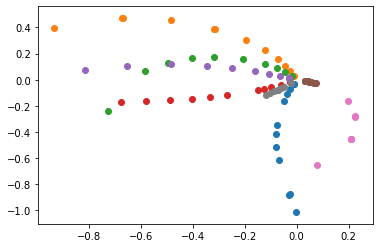

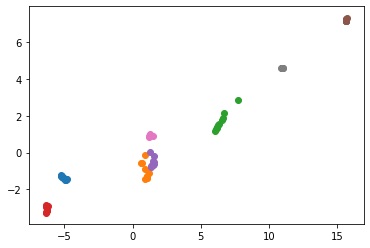

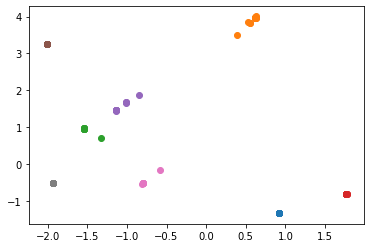

<Figure size 432x288 with 0 Axes>

In [20]:
j = 1
to_plot = [orig_xyz[j], emb_metric[j], emb_gnn[j]]
for emb in to_plot:
    plot_clusters(emb[:,0], emb[:,1], pid[j])

### DBSCAN
Cluster the embeddings output by the GNN for final evaluation.

In [21]:
# Cluster
from sklearn.cluster import DBSCAN

c = DBSCAN(eps=.24, min_samples=3)

def get_clusters(embedding):
    return c.fit_predict(embedding)

# Scoring
The score of one predicted cluster is nonzero only if a large majority ofits points belong to the same true cluster, and if the majority of the true cluster iscontained within the predicted cluster.  A perfect clustering will thus lead to a score of 1, while a random clustering will almost certainly have a score of 0.

In [22]:
# Score samples
from gnn_utils import score_event

In [23]:
### Get final cluster scores
import pandas

avg_score = 0.0
nb_samples = 20
for i in range(nb_samples):
    # emb = samples[i]['hits']['emb']
    # clusters = get_clusters(emb)
    clusters = get_clusters(emb_gnn[i])
    hit_ids = np.arange(len(clusters))
    truth = pandas.DataFrame.from_dict({'particle_id':pid[i].numpy(),
                                        'hit_id':hit_ids,
                                        'weight':weight[i].numpy()})
    submission = pandas.DataFrame.from_dict({'hit_id':hit_ids,
                                             'track_id':clusters})
    score = score_event(truth, submission)
    avg_score += score
print("TrackML score: {:.2f}".format(avg_score / nb_samples))

TrackML score: 0.89
